Forked from [Kun Hao Yeh notebook](https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-inference-tta) and changed some small parameters.

Please upvote the original notebook as well

In [1]:
import torch
torch.cuda.get_device_name()

'Tesla T4'

In [2]:
!git clone https://github.com/NVIDIA/apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

fatal: destination path 'apex' already exists and is not an empty directory.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-ttb6q1yu
Created temporary directory: /tmp/pip-req-tracker-vwema6av
Created requirements tracker '/tmp/pip-req-tracker-vwema6av'
Created temporary directory: /tmp/pip-install-rpiqtrrk
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-najynief
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-vwema6av'
    Running setup.py (path:/tmp/pip-req-build-najynief/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info


    torch.__version__  = 1.7.0+cu101


    running egg_info
    creating /tmp/pip-req-build-najynief/pip-egg-info/apex.egg-info

In [3]:
%%bash
pip install timm
pip install -U catalyst
pip install -U git+https://github.com/albumentations-team/albumentations
pip install vision_transformer_pytorch

Requirement already up-to-date: catalyst in /usr/local/lib/python3.6/dist-packages (20.12)
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ilr0u24a
  Created wheel for albumentations: filename=albumentations-0.5.2-cp36-none-any.whl size=79948 sha256=e157bd66867e6e68842c5f6625efa7e6ca6d16269df134757bbc6bc05e7aa606
  Stored in directory: /tmp/pip-ephem-wheel-cache-5xjx_0wd/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ilr0u24a


In [1]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from  torch.cuda.amp import autocast, GradScaler

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
#import pydicom
import timm #from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom
from sklearn.metrics import log_loss

In [2]:
from sklearn.model_selection import StratifiedKFold
import collections

In [3]:
from catalyst.utils import set_global_seed, prepare_cudnn, get_device
import multiprocessing
from matplotlib import pyplot as plt 
import seaborn as sns

from typing import Callable, List, Tuple 
from vision_transformer_pytorch import VisionTransformer


from catalyst.dl import utils
##from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose
from catalyst.utils import imread
#from catalyst.utils.dataset import create_dataset, create_dataframe, prepare_dataset_labeling
#from catalyst.utils.pandas import map_dataframe
#from catalyst.data.dataset import PathsDataset
#from catalyst.utils.dataset import split_dataframe, stratified_fold_split, default_fold_split, create_dataset
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.nn.criterion.focal import FocalLossMultiClass
from catalyst.dl.callbacks import AccuracyCallback, AUCCallback, F1ScoreCallback
from catalyst.contrib.nn.schedulers.onecycle import OneCycleLRWithWarmup
#from catalyst.data.augmentor import Augmentor
from catalyst.contrib.nn.optimizers import RAdam, Lookahead

from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, OptimizerCallback


In [4]:
CFG = {
    'fold_num': 10,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 384,
    'epochs': 32,
    'train_bs': 16,
    'valid_bs': 16,
    'lr': 1e-4,
    'num_workers': 4,
    'accum_iter': 1, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0',
    'tta': 3,
    'used_epochs': [6,7,8,9],
    'weights': [1,1,1,1]
}

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
root = os.getcwd()
root = Path('/content/drive/MyDrive/cassava-leaf-disease-classification/archive')
root

PosixPath('/content/drive/MyDrive/cassava-leaf-disease-classification/archive')

In [7]:
train = pd.read_csv(root / 'merged.csv')
train.head()

image_id  label  source
0  1000015157.jpg      0    2020
1  1000201771.jpg      3    2020
2   100042118.jpg      1    2020
3  1000723321.jpg      1    2020
4  1000812911.jpg      3    2020

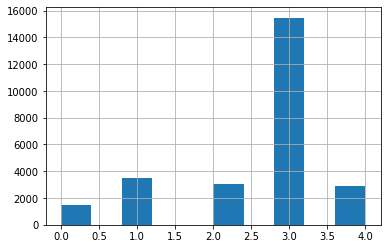

In [8]:
train.label.hist()

> We could do stratified validation split in each fold to make each fold's train and validation set looks like the whole train set in target distributions.

# Helper Functions

In [9]:
NUM_CORES = multiprocessing.cpu_count() - 1
SEED = 2021
NUM_CORES

1

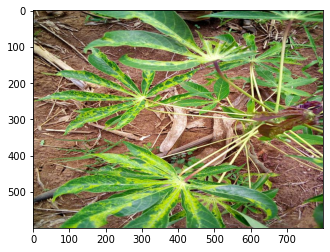

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def seed_everything(seed):
    set_global_seed(SEED)
    prepare_cudnn()
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print(f'SEED: {SEED}')
 
def show_examples(images: List[Tuple[str, np.ndarray]]):
    examples = len(images)
    width = int(examples ** .5)
    height = examples // width
    _indexes = [(i, j) for i in range(height) for j in range(width)]
    
    f, ax = plt.subplots(height, width, figsize=(16, 16))
    for (i, j), (title, img) in zip(_indexes, images):
        ax[i, j].imshow(img)
        ax[i, j].set_title(title)
    f.tight_layout()

def read_random_images(paths: List[Path], size: int=4) -> List[Tuple[str, np.ndarray]]:
    data = np.random.choice(paths, size)
    result = []
    for d in data:
        name = d.name
        #title = '_'.join([str(i) for i in train[train.image_id == name].values[0]])
        title = train[train.image_id == name].values[0][3]
        _image = get_img(d)
        result.append((title, _image))
    
    return result

def get_img(path):
    im_bgr = cv2.imread(str(path))
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img(root / 'train/1000201771.jpg')
plt.imshow(img)
plt.show()

In [11]:
root / 'train/1000201771.jpg'

PosixPath('/content/drive/MyDrive/cassava-leaf-disease-classification/archive/train/1000201771.jpg')

In [12]:
class_map = pd.read_json('/content/drive/MyDrive/cassava-leaf-disease-classification/label_num_to_disease_map.json',
             orient='index')
class_map

0
0       Cassava Bacterial Blight (CBB)
1  Cassava Brown Streak Disease (CBSD)
2           Cassava Green Mottle (CGM)
3         Cassava Mosaic Disease (CMD)
4                              Healthy

In [13]:
'_'.join([str(i) for i in train[train.image_id == '1000015157.jpg'].values[0]])


'1000015157.jpg_0_2020'

In [14]:
train = train.merge(class_map, left_on='label', right_index=True)
train

image_id  label  source                               0
0             1000015157.jpg      0    2020  Cassava Bacterial Blight (CBB)
7             1001320321.jpg      0    2020  Cassava Bacterial Blight (CBB)
18            1003888281.jpg      0    2020  Cassava Bacterial Blight (CBB)
73            1012426959.jpg      0    2020  Cassava Bacterial Blight (CBB)
109           1018973237.jpg      0    2020  Cassava Bacterial Blight (CBB)
...                      ...    ...     ...                             ...
26252   train-healthy-82.jpg      4    2019                         Healthy
26297  train-healthy-163.jpg      4    2019                         Healthy
26305  train-healthy-189.jpg      4    2019                         Healthy
26319  train-healthy-243.jpg      4    2019                         Healthy
26335  train-healthy-236.jpg      4    2019                         Healthy

[26337 rows x 4 columns]

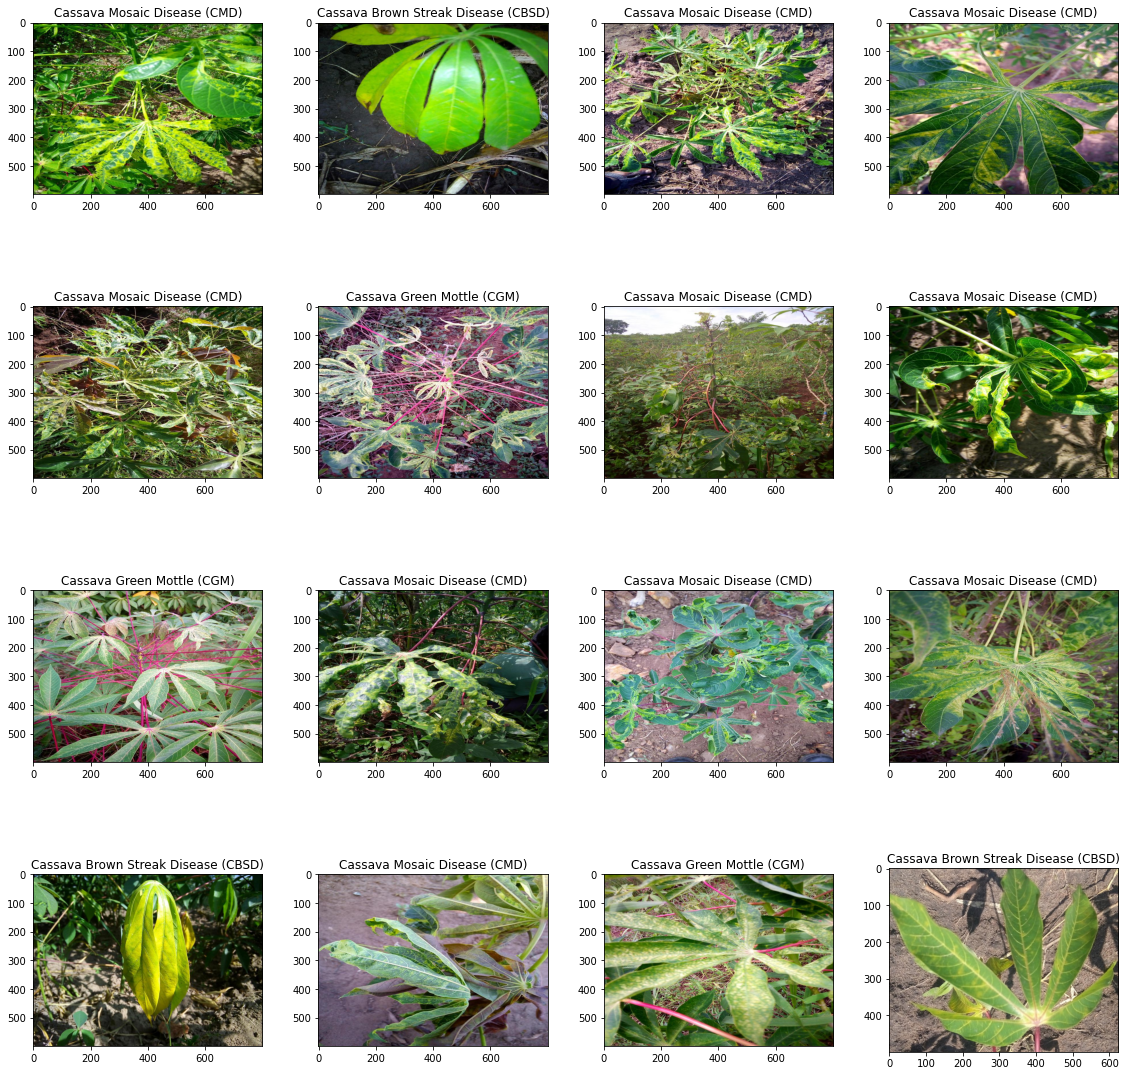

In [15]:
TRAIN_DIR = root / 'train'
train_imades = list(Path(TRAIN_DIR).glob("**/*.jpg"))
images = read_random_images(train_imades, 16)
show_examples(images)

# Define Train\Validation Image Augmentations

In [16]:
mean = [0.4589, 0.5314, 0.3236]
std = [0.2272, 0.2297, 0.2200]

In [17]:
# from albumentations import (
#     HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
#     Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
#     IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
#     IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
# )

# from albumentations.pytorch import ToTensorV2

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, 
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, 
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, ShiftScaleRotate, CenterCrop, Resize,SmallestMaxSize
    # RandomSunFlare, RandomShadow
)

from albumentations import RandomResizedCrop, CoarseDropout, RandomGridShuffle
from albumentations.pytorch import ToTensorV2

img_size = 456
def get_train_transforms():
    return Compose([
            # CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            #Resize(CFG['img_size'], CFG['img_size']),
            SmallestMaxSize(img_size,interpolation=2, p=1.),

            CenterCrop(img_size, img_size, p=1.),

            #RandomResizedCrop(img_size, img_size),
            Transpose(p=0.5),
            Flip(p=0.5),
            # VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            # HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            # RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            # CoarseDropout(p=0.5),
            # Cutout(p=0.5),
            RandomGridShuffle(grid=(3, 3), p=0.5),  
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),

            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            SmallestMaxSize(img_size,interpolation=2, p=1.),

            CenterCrop(img_size, img_size, p=1.),
            # CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            # Resize(CFG['img_size'], CFG['img_size']),
            # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),

            ToTensorV2(p=1.0),
        ], p=1.)

def get_inference_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [18]:
def show_transforms():
    return Compose([
            #CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            SmallestMaxSize(img_size,interpolation=2, p=1.),

            CenterCrop(img_size, img_size, p=1.),
                    
            #RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            # Transpose(p=0.5),
            # HorizontalFlip(p=0.5),
            # VerticalFlip(p=0.5),
            # ShiftScaleRotate(p=0.5),
            # HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            # RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            # #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            # CoarseDropout(p=0.5),
            # Cutout(num_holes=20, max_h_size=20, max_w_size=20, fill_value=(128,128,128), p=0.5),   
            # RandomGridShuffle(grid=(4, 4), p=0.5),    
            #RandomSunFlare(flare_roi=(0, 0, 1, 1), num_flare_circles_lower=10, num_flare_circles_upper=20, angle_lower=0.5, src_radius=100,  p=1),
            #RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=3, shadow_roi=(0, 0.5, 1, 1), p=1),
            #Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),

        ], p=1.)
  

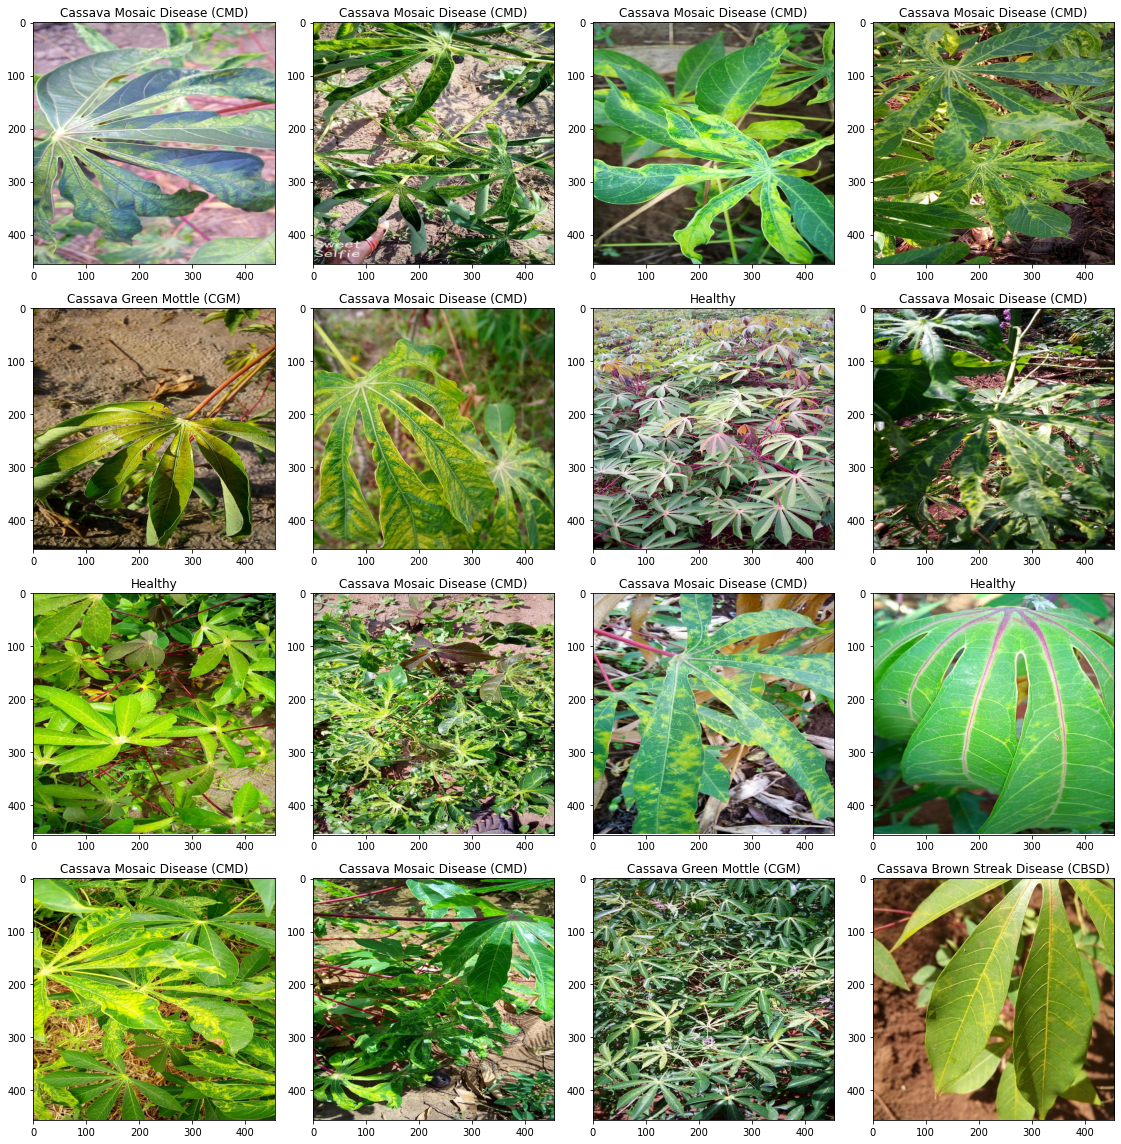

In [19]:
transforms = show_transforms()
images = read_random_images(train_imades, 16)

images = [
    (title, transforms(image=i)["image"])
    for (title, i) in images
]
show_examples(images);

# Dataset

In [20]:
class CassavaDataset(Dataset):
    def __init__(
        self, df, data_root, transforms=None, output_label=True
    ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.output_label = output_label
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.df.iloc[index]['label']
          
        #path = "{}/{}".format(self.data_root, self.df.iloc[index]['image_id'])
        # root / 'test_images/'

        path = self.data_root / self.df.iloc[index]['image_id']
        img  = get_img(path)
        
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        # do label smoothing
        if self.output_label == True:
            return img, target
        else:
            return img

In [21]:
# def get_loaders(fold: int, BS: int, img_size: int=224, waveform_transforms=None):

#     train_all = pd.read_csv(INPUT_ROOT / "train_all.csv")[:100]

#     # # split dataset
#     train_file_list = train_all.query("fold != @fold")[["file_path", "ebird_code"]].values.tolist()
#     val_file_list = train_all.query("fold == @fold")[["file_path", "ebird_code"]].values.tolist()

#     print("[fold {}] train: {}, val: {}".format(fold, len(train_file_list), len(val_file_list)))

#     # # make dataset
#     train_dataset = SpectrogramDataset(train_file_list,
#                                         img_size=img_size,
#                                         waveform_transforms=waveform_transforms,
#                                         spectrogram_transforms=None,) #**args_dataset)
#     val_dataset = SpectrogramDataset(val_file_list,
#                                         img_size=img_size,
#                                         waveform_transforms=None,
#                                         spectrogram_transforms=None,) #**args_dataset)
#     # # make dataloader
#     train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=4, pin_memory=True, drop_last=True )#**args_loader["train"])
#     val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=True, num_workers=4, pin_memory=True, drop_last=True) #**args_loader["val"])
    
#     return train_loader, val_loader


TRAIN: [    0     1     4 ... 26333 26335 26336] TEST: [    2     3     6 ... 26313 26325 26334]
TRAIN: [    0     2     3 ... 26334 26335 26336] TEST: [    1    13    14 ... 26314 26329 26331]
TRAIN: [    1     2     3 ... 26334 26335 26336] TEST: [    0     5     8 ... 26311 26316 26318]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



TRAIN: [    0     1     2 ... 26334 26335 26336] TEST: [   12    19    34 ... 26308 26319 26323]
TRAIN: [    0     1     2 ... 26332 26334 26335] TEST: [   11    17    18 ... 26328 26333 26336]
TRAIN: [    0     1     2 ... 26334 26335 26336] TEST: [    4    10    15 ... 26322 26330 26332]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



TRAIN: [    0     1     2 ... 26333 26334 26336] TEST: [    7     9    20 ... 26324 26326 26335]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



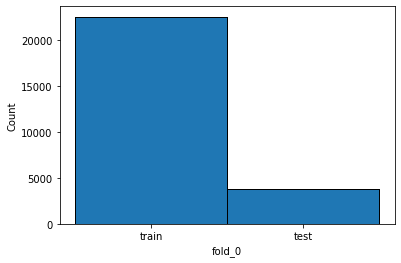

In [22]:
skf = StratifiedKFold(n_splits=7, random_state=SEED, shuffle=True)

for  i, (train_index, test_index) in enumerate(skf.split(train['image_id'], train['label'])):
    print("TRAIN:", train_index, "TEST:", test_index)
    train[f"fold_{i}"] = "train"
    train[f"fold_{i}"][test_index] = "test"
    sns.histplot(train[f"fold_{i}"])
    # X_train, X_test = X[train_index], X[test_index]
    # y_train, y_test = y[train_index], y[test_index]

In [23]:
i = 2
train_ds = CassavaDataset(train[train[f"fold_{i}"] == 'train'], root / 'train/', transforms=get_train_transforms())
        
train_loader = torch.utils.data.DataLoader(
            train_ds, 
            batch_size=16,
            num_workers=CFG['num_workers'],
            shuffle=True,
            pin_memory=False,
        )

test_ds = CassavaDataset(train[train[f"fold_{i}"] == 'test'], root / 'train/', transforms=get_valid_transforms())
        
valid_loader = torch.utils.data.DataLoader(
            test_ds, 
            batch_size=16,
            #num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=False,
        )        

In [24]:
loaders = collections.OrderedDict()
loaders["train"] = train_loader
loaders["valid"] = valid_loader

In [25]:
next(iter(loaders["train"]))[1].shape

torch.Size([16])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


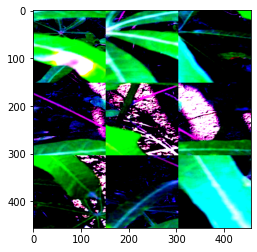

In [26]:
plt.imshow(train_ds[0][0].transpose(0, 2));

# Model

In [27]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
class EnsembleClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model1 = VisionTransformer.from_pretrained('ViT-B_32', num_classes=5) 
        #self.model1.load_state_dict(torch.load('../input/vit-model-1/ViT-B_16.pt'))
        self.model2 = CassvaImgClassifier(model_arch, n_class, pretrained)
        
    def forward(self, x):
        x1 = self.model1(x)
        x2 = self.model2(x)
        return 0.6 * x1 + 0.4 * x2
    
    def load(self, state_dict):
        self.model2.load_state_dict(state_dict)

In [28]:
def get_model(model_name: str, num_classes: int, pretrained: str = "imagenet"):

    if 'resne' in model_name:
        model = timm.create_model(model_name, pretrained=True)
        dim_feats = model.fc.in_features
        model.fc = nn.Linear(dim_feats, num_classes)
    else:
        model = timm.create_model(model_name, pretrained=True)
        dim_feats = model.classifier.in_features
        model.classifier = nn.Linear(dim_feats, num_classes)

    return model

def get_lr(model_name: str, head_lr=3e-4, reduce=0.1):

    if 'resnet' in model_name:
        # Set params for se_resnet
        lr = [
            #{'params': model.conv1.parameters(), 'lr': head_lr * reduce * reduce}, 
            {'params': model.layer1.parameters(), 'lr': head_lr * reduce * reduce}, 
            {'params': model.layer2.parameters(), 'lr': head_lr * reduce}, 
            {'params': model.layer3.parameters(), 'lr': head_lr * reduce * 1.5}, 
            {'params': model.layer4.parameters(), 'lr': head_lr * reduce * 1.5}, 
            {'params': model.last_linear.parameters(), 'lr': head_lr},
        ]
    elif 'seresnext' in model_name:    
        # Set params for resnext
        lr = [
            #{'params': model.layer0.parameters(), 'lr': head_lr * reduce * reduce}, 
            {'params': model.layer1.parameters(), 'lr': head_lr * reduce}, 
            {'params': model.layer2.parameters(), 'lr': head_lr * reduce}, 
            {'params': model.layer3.parameters(), 'lr': head_lr * reduce * 1.5}, 
            {'params': model.layer4.parameters(), 'lr': head_lr * reduce * 1.5}, 
            {'params': model.fc.parameters(), 'lr': head_lr},
        ]
    else:
        # Set params for efficientnet
        lr = [
            {'params': model.conv_stem.parameters(), 'lr': reduce * reduce},
            {'params': model.blocks.parameters(), 'lr': reduce},
            {'params': model.conv_head.parameters(), 'lr': reduce * 1.5},
            {'params': model.classifier.parameters(), 'lr': head_lr},
        ]

    return lr


In [29]:
device = get_device()
print(f"device: {device}")
#model = EnsembleClassifier(CFG['model_arch'], train.label.nunique()).to(device)

num_classes = 5
model_name = 'tf_efficientnet_b5_ns'  #"seresnext50_32x4d"
model = get_model(model_name, num_classes)
lr = get_lr(model_name, 3e-3)

device: cuda


# Main Loop

In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(lr)
#base_optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001) # model_params, weight_decay=0.0003)
optimizer = torch.optim.AdamW(lr)
#optimizer = Lookahead(base_optimizer)
scheduler = OneCycleLRWithWarmup(
    optimizer, 
    num_steps=10, 
    lr_range=(0.005, 0.0001),
    warmup_steps=1)
logdir = f"{root}/logs_{22}"

runner = SupervisedRunner(device=device)

runner.train(
                    model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    loaders=loaders,
                    callbacks=[
                            AccuracyCallback(),
                        # F1ScoreCallback(
                        #     input_key="targets_one_hot",
                        #     activation="Softmax")
                        OptimizerCallback(accumulation_steps=4),
                        ],
                    logdir=logdir,
                    num_epochs=30,
                    # main_metric= "accuracy",
                    # minimize_metric=False,
                    fp16=True,
                    verbose=True)
    


1/30 * Epoch (train):   0% 0/1411 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



1/30 * Epoch (train): 100% 1411/1411 [21:21<00:00,  1.10it/s, accuracy01=0.857, loss=0.352, lr=0.005, momentum=0.800]
1/30 * Epoch (valid): 100% 236/236 [02:08<00:00,  1.83it/s, accuracy01=0.667, loss=1.063]
[2020-12-28 20:34:32,706] 
1/30 * Epoch 1 (_base): lr=0.0050 | momentum=0.8000
1/30 * Epoch 1 (train): accuracy01=0.7763 | loss=0.6443 | lr=0.0030 | momentum=0.8499
1/30 * Epoch 1 (valid): accuracy01=0.8145 | loss=0.5498
2/30 * Epoch (train): 100% 1411/1411 [21:22<00:00,  1.10it/s, accuracy01=1.000, loss=0.207, lr=0.004, momentum=0.821]
2/30 * Epoch (valid): 100% 236/236 [02:08<00:00,  1.83it/s, accuracy01=1.000, loss=0.253]
[2020-12-28 20:58:11,120] 
2/30 * Epoch 2 (_base): lr=0.0045 | momentum=0.8211
2/30 * Epoch 2 (train): accuracy01=0.8093 | loss=0.5503 | lr=0.0047 | momentum=0.8106
2/30 * Epoch 2 (valid): accuracy01=0.8366 | loss=0.4826
3/30 * Epoch (train): 100% 1411/1411 [21:21<00:00,  1.10it/s, accuracy01=0.929, loss=0.531, lr=0.004, momentum=0.842]
3/30 * Epoch (valid): 10